<img width="200" src="https://raw.githubusercontent.com/lukwies/mid-bootcamp-project/main/data/img/bikes.png">


# Bikesharing in Seoul / Exploration

---

### Sources

 * Data: https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand
 * Image: https://global.chinadaily.com.cn/a/201801/25/WS5a69cab3a3106e7dcc136a6d.html

---

### Tasks

 * Check for unique values
 * Find outliers
 * Figure out distributions
 * Create plots:
    * by time:
        * season
        * month
        * hour
        * holiday
    * by weather:
        * temperature
        * rainfall (rain/snow)
        * wind
        * visibility
    

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
import matplotlib.pyplot as plt

#### Load YAML config file

In [4]:
with open('../params.yaml') as file:
    config = yaml.safe_load(file)

#### Read cleaned data

In [5]:
df = pd.read_csv(config['data']['csv_cleaned'])
df.head()

,date,month,hour,daytime,seasons,holiday,functioning_day,temperature,temperature_type,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,rented_bike_count
0,2017-12-01,12,0,Night,Winter,No,Yes,-5.2,Frost,37,2.2,2000,0.0,0.0,0.0,254
1,2017-12-01,12,1,Night,Winter,No,Yes,-5.5,Frost,38,0.8,2000,0.0,0.0,0.0,204
2,2017-12-01,12,2,Night,Winter,No,Yes,-6.0,Frost,39,1.0,2000,0.0,0.0,0.0,173
3,2017-12-01,12,3,Night,Winter,No,Yes,-6.2,Frost,40,0.9,2000,0.0,0.0,0.0,107
4,2017-12-01,12,4,Morning,Winter,No,Yes,-6.0,Frost,36,2.3,2000,0.0,0.0,0.0,78


In [7]:
def show_unique_values(df):
    for col in df.columns:
        print(f"COLUMN \x1b[1;31m{col}\x1b[0m ({df[col].dtype})")
        #if df[col].dtype == np.number:
        #    print(df[col].nunique())
        #else:
        print(df[col].unique())
        print()

In [8]:
show_unique_values(df)

COLUMN date (object)
['2017-12-01' '2017-12-02' '2017-12-03' '2017-12-04' '2017-12-05'
 '2017-12-06' '2017-12-07' '2017-12-08' '2017-12-09' '2017-12-10'
 '2017-12-11' '2017-12-12' '2017-12-13' '2017-12-14' '2017-12-15'
 '2017-12-16' '2017-12-17' '2017-12-18' '2017-12-19' '2017-12-20'
 '2017-12-21' '2017-12-22' '2017-12-23' '2017-12-24' '2017-12-25'
 '2017-12-26' '2017-12-27' '2017-12-28' '2017-12-29' '2017-12-30'
 '2017-12-31' '2018-01-01' '2018-01-02' '2018-01-03' '2018-01-04'
 '2018-01-05' '2018-01-06' '2018-01-07' '2018-01-08' '2018-01-09'
 '2018-01-10' '2018-01-11' '2018-01-12' '2018-01-13' '2018-01-14'
 '2018-01-15' '2018-01-16' '2018-01-17' '2018-01-18' '2018-01-19'
 '2018-01-20' '2018-01-21' '2018-01-22' '2018-01-23' '2018-01-24'
 '2018-01-25' '2018-01-26' '2018-01-27' '2018-01-28' '2018-01-29'
 '2018-01-30' '2018-01-31' '2018-02-01' '2018-02-02' '2018-02-03'
 '2018-02-04' '2018-02-05' '2018-02-06' '2018-02-07' '2018-02-08'
 '2018-02-09' '2018-02-10' '2018-02-11' '2018-02-12' '2

#### Get description of numeric and categorical columns

In [9]:
display(df.describe().T)
display(df.describe(include=object).T)

,count,mean,std,min,25%,50%,75%,max
month,8760.0,6.526027,3.448048,1.0,4.00,7.00,10.00,12.00
hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
temperature,8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
humidity,8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
wind_speed,8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
visibility,8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
solar_radiation,8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
rainfall,8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
snowfall,8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80
rented_bike_count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00


,count,unique,top,freq
date,8760,365,2017-12-01,24
daytime,8760,5,Morning,2555
seasons,8760,4,Spring,2208
holiday,8760,2,No,8328
functioning_day,8760,2,Yes,8465
temperature_type,8760,5,Cold,2164


#### Detect and plot outliers

In [10]:
def get_outlier_count(data):
    df = data.copy()

    d = {}
    for col in df.select_dtypes(np.number).columns:
        
        iqr = np.percentile(df[col], 75) - np.percentile(df[col], 25)
        upper_limit = np.percentile(df[col],75) + 1.5*iqr
        lower_limit = np.percentile(df[col],25) - 1.5*iqr
        
        d[col] = df[(df[col] < lower_limit) | (df[col] > upper_limit)].shape[0]

    return d

In [11]:
out = get_outlier_count(df)
out

{'month': 0,
 'hour': 0,
 'temperature': 0,
 'humidity': 0,
 'wind_speed': 161,
 'visibility': 0,
 'solar_radiation': 641,
 'rainfall': 528,
 'snowfall': 443,
 'rented_bike_count': 158}

In [12]:
def plot_outliers(data):
    fig,ax = plt.subplots(2,4, figsize=(7,5))
    plt.tight_layout()
    ax[0,0].set_title('rented_bike_count')
    sns.boxplot(df['rented_bike_count'], ax=ax[0,0], color='red')
    ax[0,1].set_title('temperature')
    sns.boxplot(df['temperature'], ax=ax[0,1])
    ax[0,2].set_title('humidity')
    sns.boxplot(df['humidity'], ax=ax[0,2])
    ax[0,3].set_title('visibility')
    sns.boxplot(df['visibility'], ax=ax[0,3])
    ax[1,1].set_title('solar_radiation')
    sns.boxplot(df['solar_radiation'], ax=ax[1,0], color='red')
    ax[1,2].set_title('rainfall')
    sns.boxplot(df['rainfall'], ax=ax[1,1], color='red')
    ax[1,3].set_title('snowfall')
    sns.boxplot(df['snowfall'], ax=ax[1,2], color='red')
    plt.show()

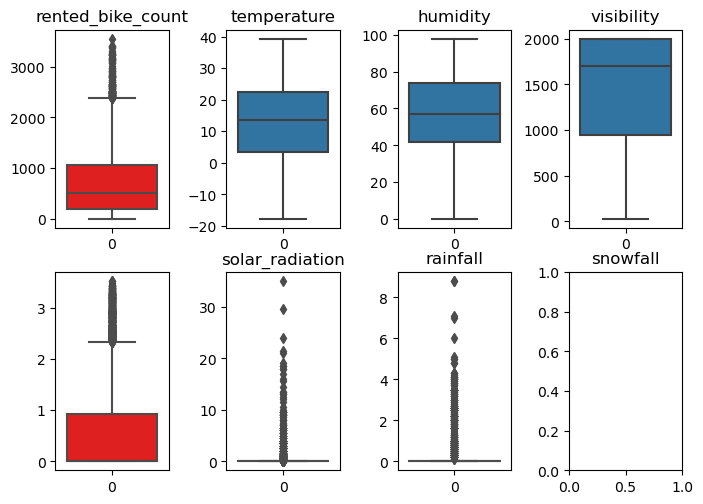

In [13]:
plot_outliers(df)

In [14]:
df['holiday'].value_counts()

No     8328
Yes     432
Name: holiday, dtype: int64

In [15]:
df['functioning_day'].value_counts()

Yes    8465
No      295
Name: functioning_day, dtype: int64

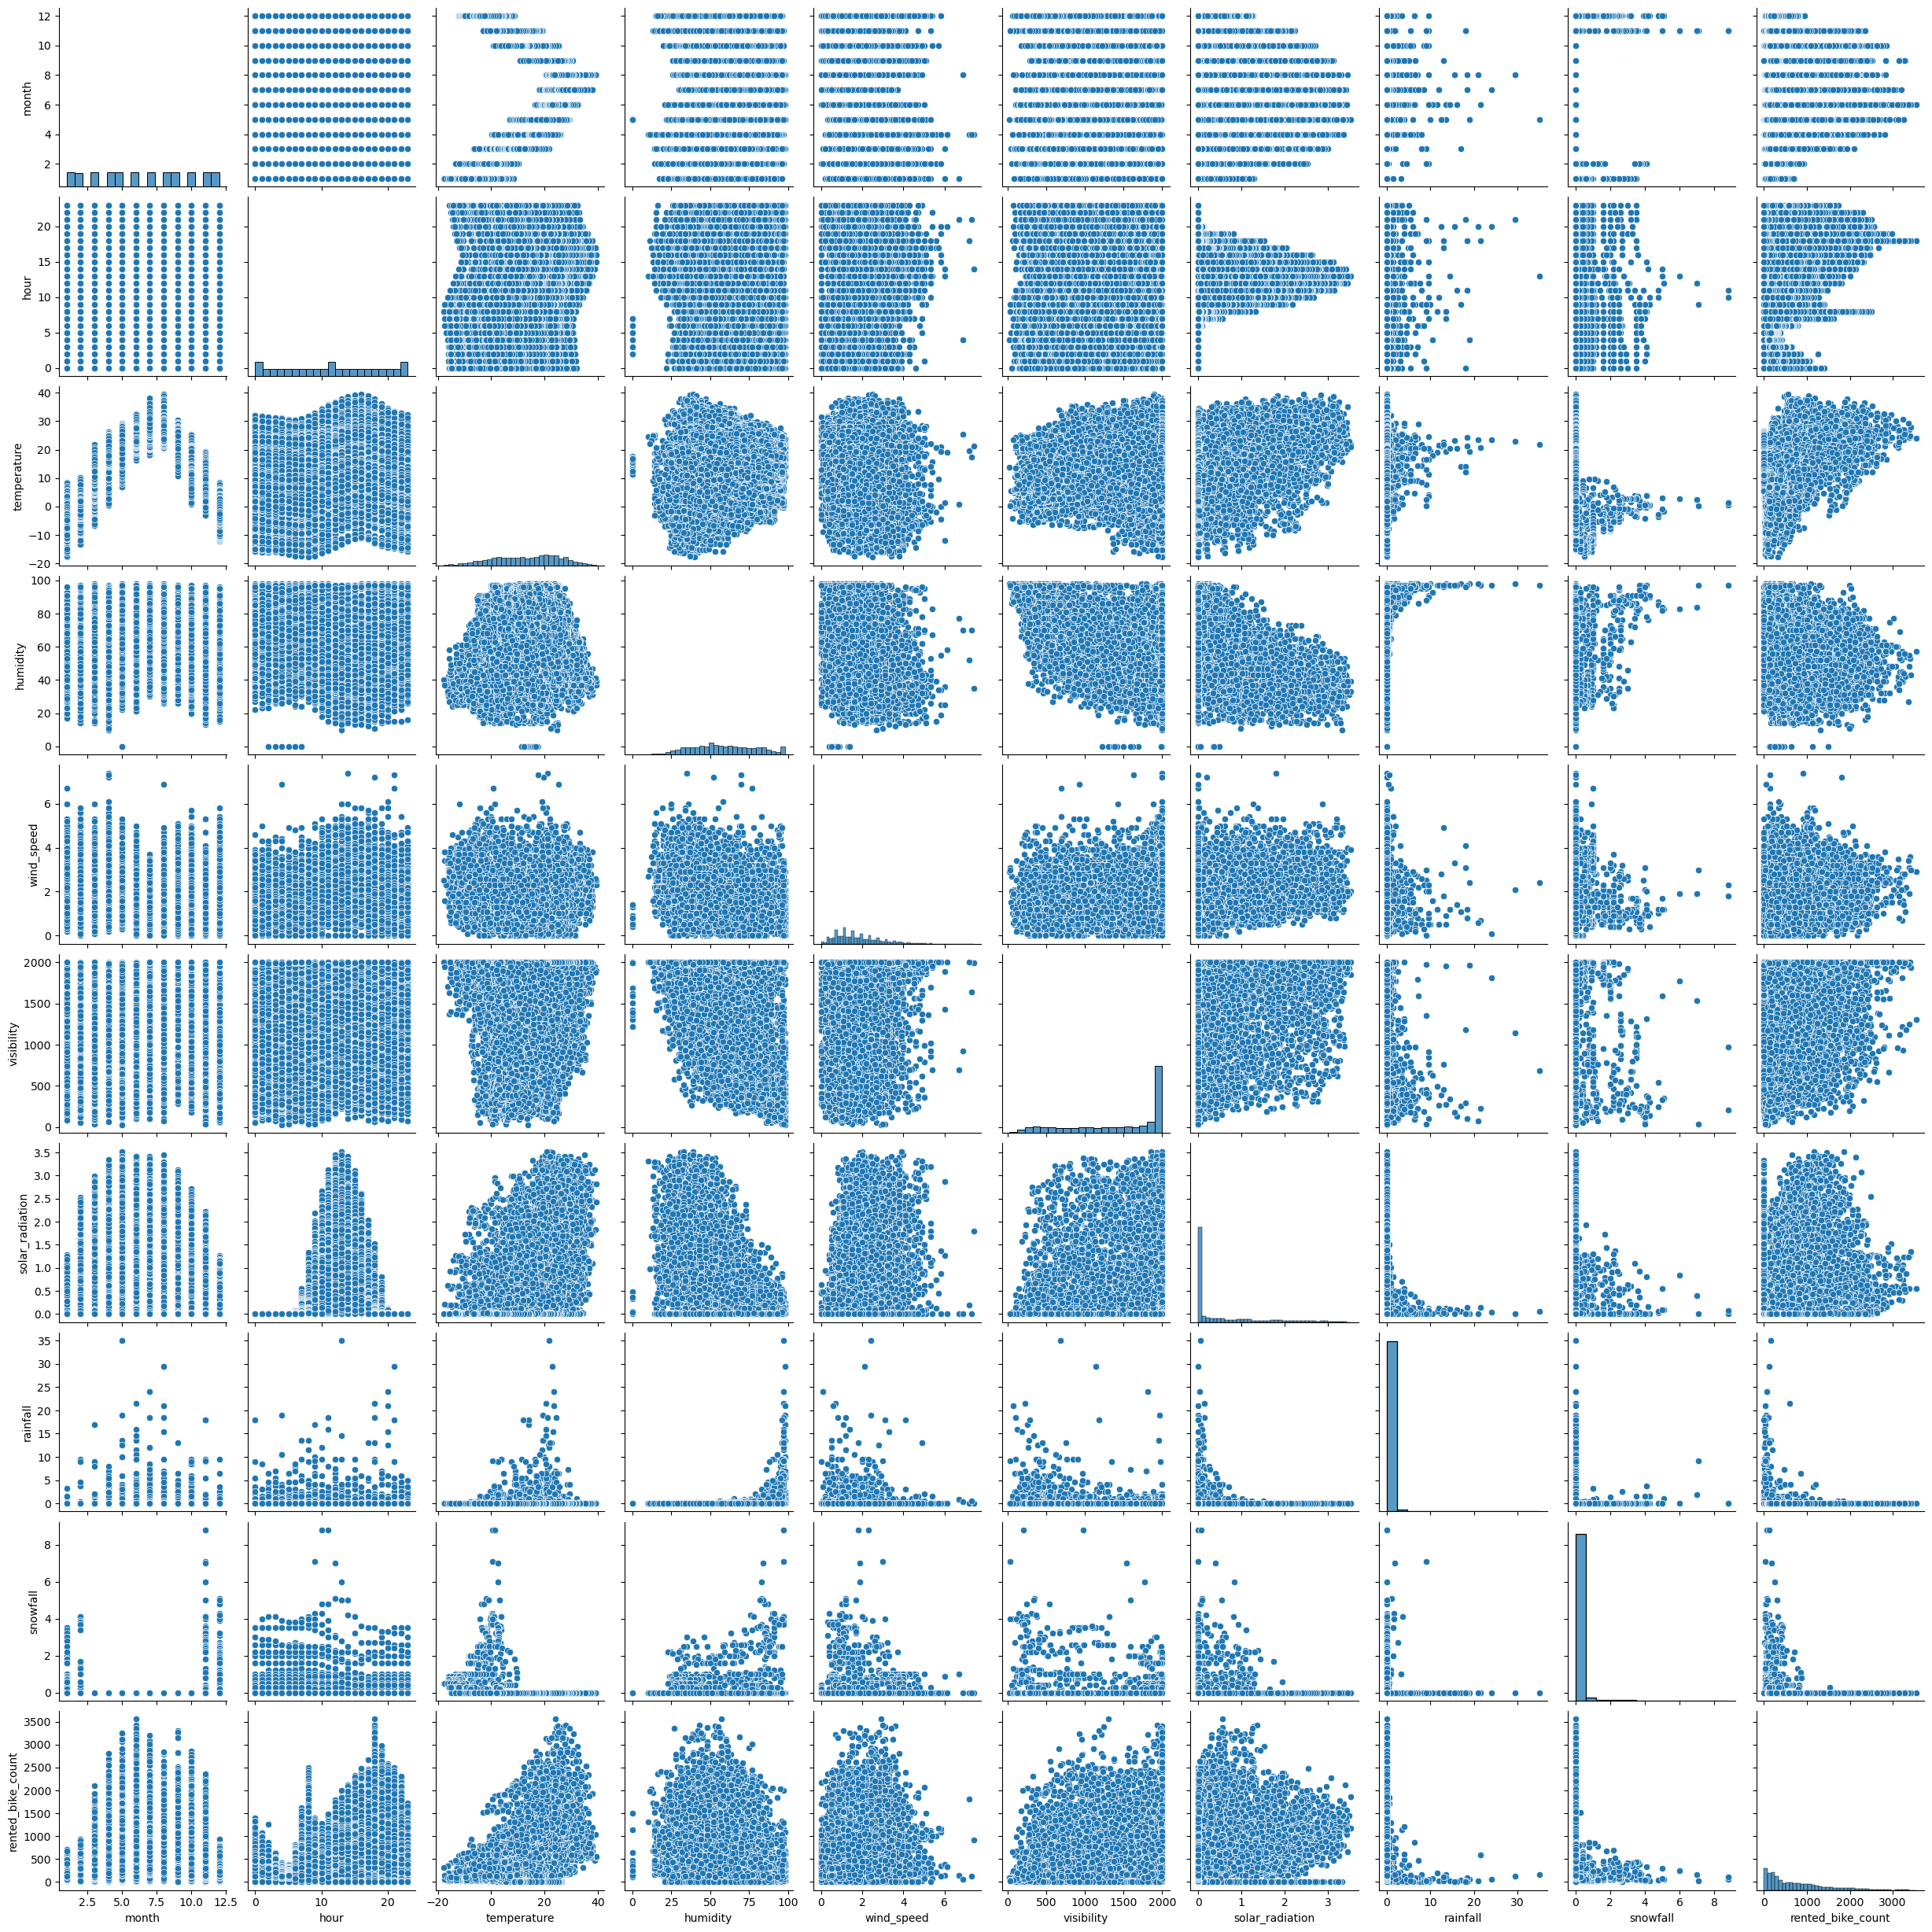

In [16]:
#sns.boxplot(x=df['temperature'], y=df['dew_point_temperature'])
#sns.lineplot(x=df['solar_radiation'], y=df['rented_bike_count'])
sns.pairplot(df)

In [17]:
#sns.heatmap(df.corr(), annot=True)

In [18]:
df.head()

,date,month,hour,daytime,seasons,holiday,functioning_day,temperature,temperature_type,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,rented_bike_count
0,2017-12-01,12,0,Night,Winter,No,Yes,-5.2,Frost,37,2.2,2000,0.0,0.0,0.0,254
1,2017-12-01,12,1,Night,Winter,No,Yes,-5.5,Frost,38,0.8,2000,0.0,0.0,0.0,204
2,2017-12-01,12,2,Night,Winter,No,Yes,-6.0,Frost,39,1.0,2000,0.0,0.0,0.0,173
3,2017-12-01,12,3,Night,Winter,No,Yes,-6.2,Frost,40,0.9,2000,0.0,0.0,0.0,107
4,2017-12-01,12,4,Morning,Winter,No,Yes,-6.0,Frost,36,2.3,2000,0.0,0.0,0.0,78


### Explore columns

#### Total/Average number of bikes rented by month

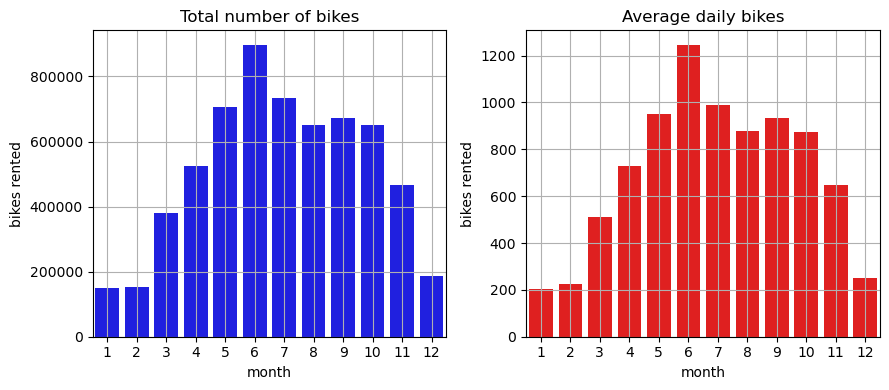

In [19]:
fig,ax = plt.subplots(1, 2, figsize=(9,4))

plot_df = df.groupby('month').agg({'rented_bike_count':'sum'}).reset_index()
sns.barplot(data=plot_df, x='month', y='rented_bike_count', color='blue', ax=ax[0])
ax[0].grid()
ax[0].set_title('Total number of bikes')
ax[0].set_ylabel('bikes rented')


plot_df = df.groupby('month').agg({'rented_bike_count':'mean'}).reset_index()
sns.barplot(data=plot_df, x='month', y='rented_bike_count', color='red', ax=ax[1])
ax[1].grid()
ax[1].set_title('Average daily bikes')
ax[1].set_ylabel('bikes rented')

plt.tight_layout()
plt.show()

#### Average number of bikes rented by hour

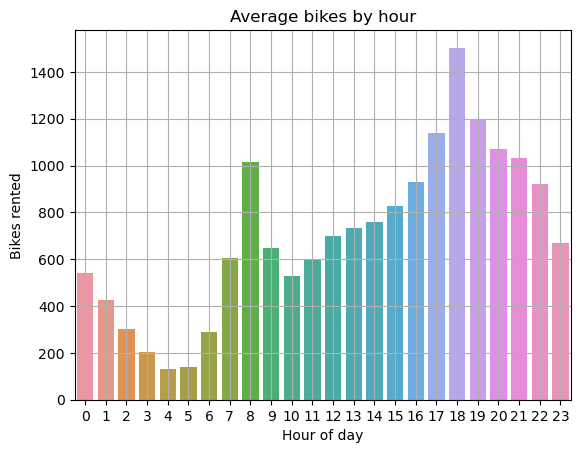

In [20]:
plot_df = df.groupby('hour').agg({'rented_bike_count':'mean'}).reset_index()
ax = sns.barplot(data=plot_df, x='hour', y='rented_bike_count')
ax.set(ylabel='Bikes rented', xlabel='Hour of day', title='Average bikes by hour')
plt.grid()
plt.show()

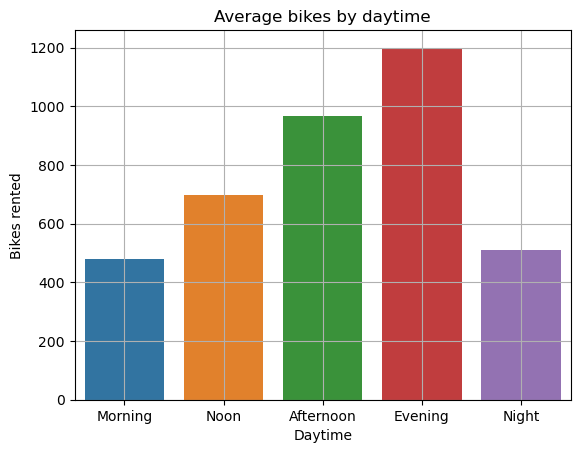

In [34]:
daytime_order = ['Morning','Noon', 'Afternoon', 'Evening', 'Night']
plot_df = df.groupby('daytime').agg({'rented_bike_count':'mean'}).reset_index()
ax = sns.barplot(data=plot_df, x='daytime', y='rented_bike_count', order=daytime_order)
ax.set(ylabel='Bikes rented', xlabel='Daytime', title='Average bikes by daytime')
plt.grid()
plt.show()

### Explore bike rentals on different seasons

In [38]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']

#### Average/Total bike rentals by season

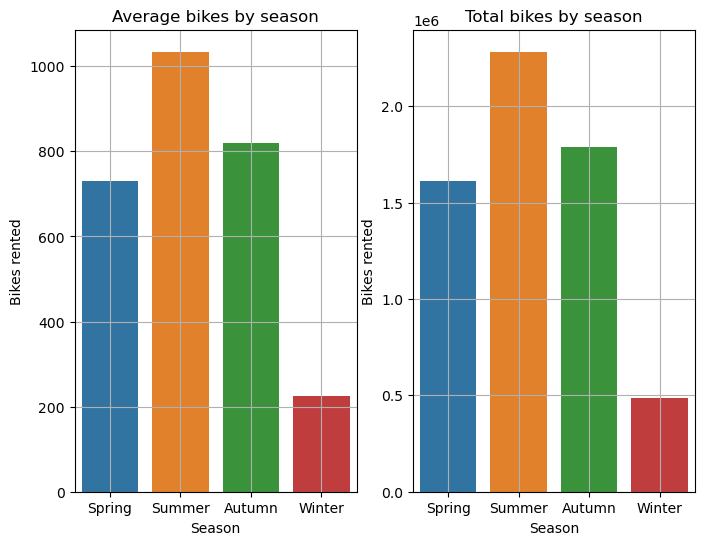

In [42]:
fig,ax = plt.subplots(1, 2, figsize=(8,6))

plot_df = df.groupby('seasons').agg({'rented_bike_count':'mean'}).reset_index()
sns.barplot(data=plot_df, x='seasons', y='rented_bike_count', ax=ax[0], order=season_order)
ax[0].set(ylabel='Bikes rented', xlabel='Season', title='Average bikes by season')
ax[0].grid()

plot_df = df.groupby('seasons').agg({'rented_bike_count':'sum'}).reset_index()
sns.barplot(data=plot_df, x='seasons', y='rented_bike_count', ax=ax[1], order=season_order)
ax[1].set(ylabel='Bikes rented', xlabel='Season', title='Total bikes by season')
ax[1].grid()


plt.show()

#### Average number of bikes rented by hour for different seasons

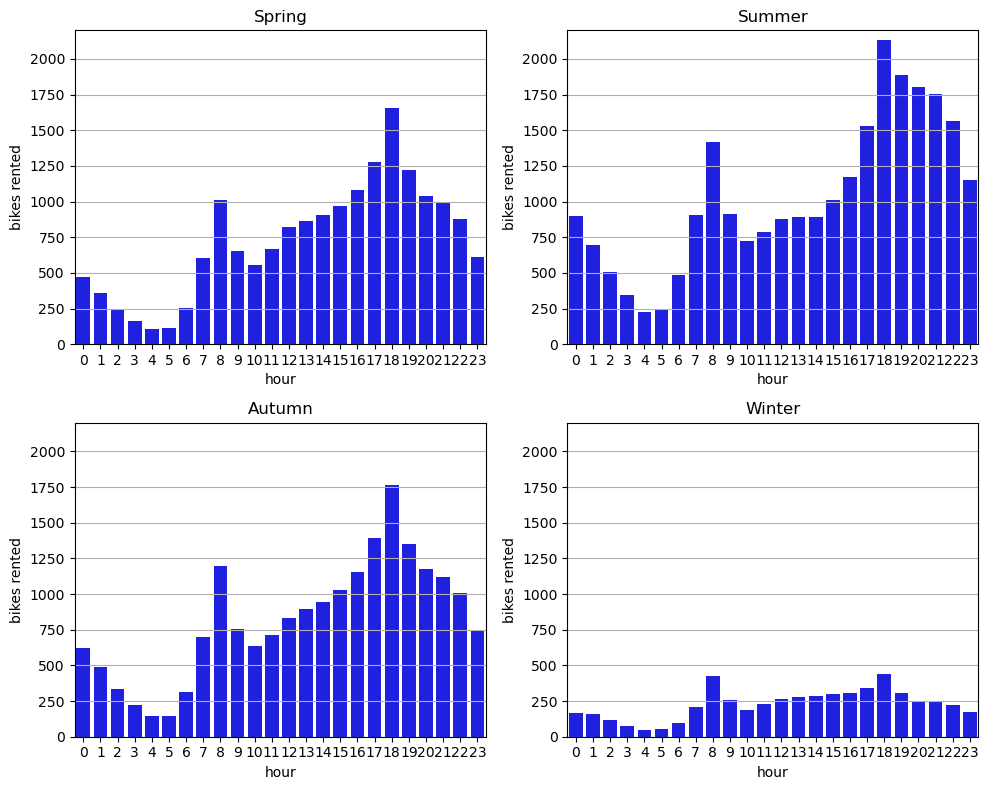

In [48]:
plot_df = df.pivot_table(index='hour', values=['rented_bike_count'], columns='seasons').reset_index()
fig,ax = plt.subplots(2, 2, figsize=(10,8))

#sns.lineplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Spring'], color='blue', ax=ax[0,0])
sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Spring'], color='blue', ax=ax[0,0])
ax[0,0].set(ylim=(0, 2200), title='Spring', ylabel='bikes rented')
ax[0,0].grid(axis='y')

sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Summer'], color='blue', ax=ax[0,1])
ax[0,1].set(ylim=(0, 2200), title='Summer', ylabel='bikes rented')
ax[0,1].grid(axis='y')

sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Autumn'], color='blue', ax=ax[1,0])
ax[1,0].set(ylim=(0, 2200), title='Autumn', ylabel='bikes rented')
ax[1,0].grid(axis='y')

sns.barplot(x=plot_df['hour'], y=plot_df['rented_bike_count']['Winter'], color='blue', ax=ax[1,1])
ax[1,1].set(ylim=(0, 2200), title='Winter', ylabel='bikes rented')
ax[1,1].grid(axis='y')

plt.tight_layout()
plt.show()

#### Average bikes by weather

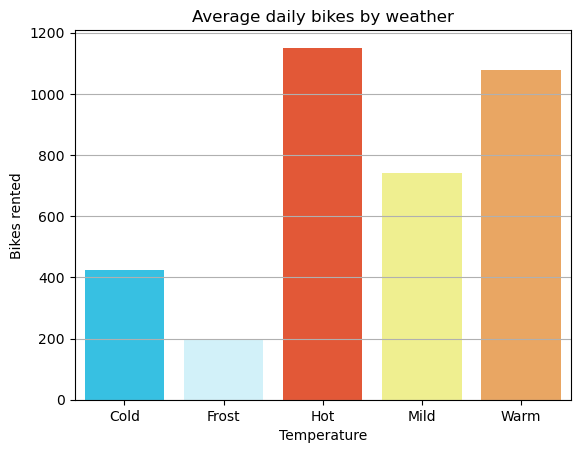

In [43]:
palette = ['#1ad1ff', '#ccf5ff', '#ff471a', '#ffff80', '#ffa64d']
plot_df = df.groupby('temperature_type').agg({'rented_bike_count':'mean'}).reset_index()
ax = sns.barplot(data=plot_df, x='temperature_type', y='rented_bike_count', palette=palette)
ax.set(ylabel='Bikes rented', xlabel='Temperature', title='Average daily bikes by weather')
plt.grid(axis='y')
plt.show()

<AxesSubplot:xlabel='temperature', ylabel='rented_bike_count'>

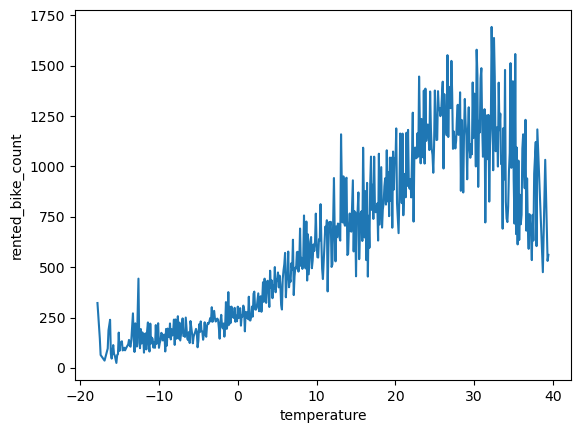

In [25]:
plot_df = df.groupby('temperature').agg({'rented_bike_count':'mean'}).reset_index()
sns.lineplot(data=plot_df, y='rented_bike_count', x='temperature')

In [26]:
df.head()

,date,month,hour,daytime,seasons,holiday,functioning_day,temperature,temperature_type,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,rented_bike_count
0,2017-12-01,12,0,Night,Winter,No,Yes,-5.2,Frost,37,2.2,2000,0.0,0.0,0.0,254
1,2017-12-01,12,1,Night,Winter,No,Yes,-5.5,Frost,38,0.8,2000,0.0,0.0,0.0,204
2,2017-12-01,12,2,Night,Winter,No,Yes,-6.0,Frost,39,1.0,2000,0.0,0.0,0.0,173
3,2017-12-01,12,3,Night,Winter,No,Yes,-6.2,Frost,40,0.9,2000,0.0,0.0,0.0,107
4,2017-12-01,12,4,Morning,Winter,No,Yes,-6.0,Frost,36,2.3,2000,0.0,0.0,0.0,78
